In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()

from sklearn.metrics import mean_absolute_error, roc_curve, RocCurveDisplay, confusion_matrix, classification_report, precision_recall_curve
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# import keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import SensitivityAtSpecificity
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential,Model

In [2]:
from tensorflow.keras.layers import BatchNormalization

## Model Setup

In [3]:
import os
os.getcwd()
os.chdir("/Users/emmatoh/Desktop/Research/Datathon/")

In [5]:
DATA_DIR="training_test_sets\\"
datasets = ["basic.npy", "basic_drug.npy", "datathon.npy", "datathon_drug.npy", "more.npy", "more_drug.npy"]

def ema_smooth_fn(patient_icp):
    EMA = 0.0
    gamma = 0.1
    patient_icp_smooth = patient_icp.copy()
    for ti in range(len(patient_icp_smooth)):
        EMA = gamma*patient_icp_smooth[ti] + (1-gamma)*EMA
        patient_icp_smooth[ti] = EMA
    return patient_icp_smooth

batch_size = 128
num_lstm_neurons = [100,100]
num_dense_neurons= [50]
num_static_neurons = [50]
dropout = 0.1
epochs = 25

def ema_smooth_scale_fn(patient_icp):
    EMA = 0.0
    gamma = 0.1
    patient_icp_smooth = patient_icp.copy()
    for ti in range(len(patient_icp_smooth)):
        EMA = gamma*patient_icp_smooth[ti] + (1-gamma)*EMA
        patient_icp_smooth[ti] = EMA
    return patient_icp_smooth

    scaler = RobustScaler(quantile_range=(1,99)).fit(patient_icp_smooth)
    return scaler.transform(patient_icp_smooth)

In [4]:
batch_size = 182
num_lstm_neurons = [50,50]
num_dense_neurons= [100]
num_static_neurons = [100]
dropout = 0.05
epochs = 20

def LSTM_model(dynamic_X, static_X):
    lstm_model = Sequential()
    """
    LSTM

        - units = dimension of hidden state. Hidden state is like an output of LSTM 
        in every timestep. This means our LSTM will be outputting <units> real numbers 
        in the end. It also means, the amount of neurons in every layer of the neuron
        in LSTM is <units>. Note that in LSTM, we have the forget gate, input gate
        and output gate.

        - input_shape = (timesteps,no. of params)

        - return_sequences = True is necessary when chaining LSTM layers, so that
        the second LSTM layer has a three-dimensional sequence input
    """
    for s in range(len(num_lstm_neurons)):
        if s == 0:
            lstm_model.add(LSTM(units=num_lstm_neurons[s], dropout=dropout, input_shape=dynamic_X.shape[1:3], return_sequences=True))
        elif s == len(num_lstm_neurons)-1:
            lstm_model.add(LSTM(units=num_lstm_neurons[s], dropout=dropout))
        else:
            lstm_model.add(LSTM(units=num_lstm_neurons[s], return_sequences=True, dropout=dropout))
            lstm_model.add(LSTM(units=num_lstm_neurons[s], return_sequences=True, dropout=0.1))

    for k in range(len(num_dense_neurons)):
        lstm_model.add(BatchNormalization())
        lstm_model.add(Dense(units=num_dense_neurons[k],activation='relu'))
        lstm_model.add(Dropout(dropout))


    # Static model
    static_model = Sequential()
    static_model.add(Input(shape=(static_X.shape[1],)))
    for s in range(len(num_static_neurons)):
        static_model.add(Dense(units=num_static_neurons[s],activation='relu'))
        static_model.add(Dropout(dropout))

    concat = Concatenate()([lstm_model.output, static_model.output])
    z = Dense(units=2)(concat)
    z = Softmax()(z)
    merged_model = Model(inputs=[lstm_model.input, static_model.input], outputs=z)

    opt = Adam(learning_rate=0.003)
    merged_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    # merged_model.compile(optimizer=opt, loss=sens_loss, metrics=['accuracy'])
#     print(merged_model.summary())
    return merged_model

### 5 fold cross-val

In [ ]:
tests_ys = []
pred_ys = []

DATA_DIR="training_test_sets\\"
datasets = ["attempt_3_zero_stdev.npy", "attempt_5_zero_30min_stdev.npy", "attempt_9_zero_60min_stdev.npy"]

for dataset in datasets[::1]:
    with open(DATA_DIR + dataset, 'rb') as f:
        train_dynamic_X = np.load(f)
        train_static_X = np.load(f)
        train_y = np.load(f)
        test_dynamic_X = np.load(f)
        test_static_X = np.load(f)
        test_y = np.load(f)
    dynam_X = np.append(train_dynamic_X, test_dynamic_X, axis=0)
    static_X = np.append(train_static_X, test_static_X, axis=0)
    y = np.append(train_y, test_y)
    
    num_samples = len(y)
    for i in range(5):
        
        val_dynamic_X = dynam_X[int(num_samples/5*i):int(num_samples/5*(i+1)), ...]
        train_dynamic_X = np.append(dynam_X[:int(num_samples/5*i), ...], dynam_X[int(num_samples/5*(i+1)):, ...], axis=0)
        val_static_X = static_X[int(num_samples/5*i):int(num_samples/5*(i+1)), ...]
        train_static_X = np.append(static_X[:int(num_samples/5*i), ...], static_X[int(num_samples/5*(i+1)):, ...], axis=0)
        val_y = y[int(num_samples/5*i):int(num_samples/5*(i+1)), ...]
        train_y = np.append(y[:int(num_samples/5*i), ...], y[int(num_samples/5*(i+1)):, ...], axis=0)
#         print(val_dynamic_X.shape, train_dynamic_X.shape, val_static_X.shape, train_static_X.shape, val_y.shape, train_y.shape)
        model = LSTM_model(train_dynamic_X, train_static_X)
        model.fit(
            [train_dynamic_X, train_static_X], train_y, 
            epochs=epochs, batch_size=batch_size, shuffle=True, 
        )

        pred_y = model.predict([val_dynamic_X, val_static_X])

        tests_ys.append(val_y)
        pred_ys.append(pred_y)
        
with open(f'cross_val_results_23_may.npy', 'wb') as f:
    for i in range(15):
        test_y, pred_y = tests_ys[i], pred_ys[i]
        np.save(f, test_y)
        np.save(f, pred_y)


In [ ]:
tests_ys = []
pred_ys = []

DATA_DIR="training_test_sets/"
datasets = ["attempt_83_stddev_30_new_1.npy", "attempt_93_icpv_30_new_1.npy"]

for dataset in datasets[::1]:
    with open(DATA_DIR + dataset, 'rb') as f:
        train_dynamic_X = np.load(f,allow_pickle=True)
        train_static_X = np.load(f,allow_pickle=True)
        train_y = np.load(f,allow_pickle=True)
        test_dynamic_X = np.load(f,allow_pickle=True)
        test_static_X = np.load(f,allow_pickle=True)
        test_y = np.load(f,allow_pickle=True)
    dynam_X = np.append(train_dynamic_X, test_dynamic_X, axis=0)
    static_X = np.append(train_static_X, test_static_X, axis=0)
    y = np.append(train_y, test_y)
    
    num_samples = len(y)
    for i in range(5):
        
        val_dynamic_X = dynam_X[int(num_samples/5*i):int(num_samples/5*(i+1)), ...]
        train_dynamic_X = np.append(dynam_X[:int(num_samples/5*i), ...], dynam_X[int(num_samples/5*(i+1)):, ...], axis=0)
        val_static_X = static_X[int(num_samples/5*i):int(num_samples/5*(i+1)), ...]
        train_static_X = np.append(static_X[:int(num_samples/5*i), ...], static_X[int(num_samples/5*(i+1)):, ...], axis=0)
        val_y = y[int(num_samples/5*i):int(num_samples/5*(i+1)), ...]
        train_y = np.append(y[:int(num_samples/5*i), ...], y[int(num_samples/5*(i+1)):, ...], axis=0)
#         print(val_dynamic_X.shape, train_dynamic_X.shape, val_static_X.shape, train_static_X.shape, val_y.shape, train_y.shape)
        model = LSTM_model(train_dynamic_X, train_static_X)
        model.fit(
            [train_dynamic_X, train_static_X], train_y, 
            epochs=epochs, batch_size=batch_size, shuffle=True, 
        )

        pred_y = model.predict([val_dynamic_X, val_static_X])

        tests_ys.append(val_y)
        pred_ys.append(pred_y)
        
with open(f'cross_val_results_11augbigboys30.npy', 'wb') as f:
    for i in range(10):
        test_y, pred_y = tests_ys[i], pred_ys[i]
        np.save(f, test_y)
        np.save(f, pred_y)


Metal device set to: Apple M2


2022-08-11 00:57:04.066548: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-11 00:57:04.066677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2022-08-11 00:57:04.446090: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-11 00:57:05.640740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 00:57:05.839772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 00:57:05.902676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 00:57:06.040103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/376 [..............................] - ETA: 6s - loss: 0.1844 - accuracy: 0.9712 

2022-08-11 00:57:06.134819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 7s 14ms/step - loss: 0.0893 - accuracy: 0.9773
Epoch 2/20
376/376 [==============================] - 5s 14ms/step - loss: 0.0664 - accuracy: 0.9809
Epoch 3/20
376/376 [==============================] - 5s 15ms/step - loss: 0.0652 - accuracy: 0.9812
Epoch 4/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0604 - accuracy: 0.9822
Epoch 5/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0587 - accuracy: 0.9828
Epoch 6/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0593 - accuracy: 0.9825
Epoch 7/20
376/376 [==============================] - 5s 14ms/step - loss: 0.0584 - accuracy: 0.9826
Epoch 8/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0584 - accuracy: 0.9826
Epoch 9/20
376/376 [==============================] - 5s 14ms/step - loss: 0.0576 - accuracy: 0.9829
Epoch 10/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0578 - accuracy: 0.9831


2022-08-11 00:58:56.552372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 00:58:56.616645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 00:58:56.655499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - 3s 5ms/step
Epoch 1/20


2022-08-11 00:59:01.140010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 00:59:01.342047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 00:59:01.382136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 00:59:01.486827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  8/376 [..............................] - ETA: 5s - loss: 0.2439 - accuracy: 0.9663 

2022-08-11 00:59:01.554170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 7s 15ms/step - loss: 0.0921 - accuracy: 0.9765
Epoch 2/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0679 - accuracy: 0.9800
Epoch 3/20
376/376 [==============================] - 5s 15ms/step - loss: 0.0642 - accuracy: 0.9808
Epoch 4/20
376/376 [==============================] - 5s 15ms/step - loss: 0.0627 - accuracy: 0.9817
Epoch 5/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0637 - accuracy: 0.9806
Epoch 6/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0626 - accuracy: 0.9814
Epoch 7/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0614 - accuracy: 0.9814
Epoch 8/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0611 - accuracy: 0.9816
Epoch 9/20
376/376 [==============================] - 5s 15ms/step - loss: 0.0611 - accuracy: 0.9816
Epoch 10/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0614 - accuracy: 0.9817


2022-08-11 01:00:52.888891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:00:52.948569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:00:52.981512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - 3s 5ms/step
Epoch 1/20


2022-08-11 01:00:57.414196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:00:57.601458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:00:57.646174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:00:57.753441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:00:57.819378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 7s 15ms/step - loss: 0.0872 - accuracy: 0.9772
Epoch 2/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0676 - accuracy: 0.9801
Epoch 3/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0649 - accuracy: 0.9807
Epoch 4/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0633 - accuracy: 0.9811
Epoch 5/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0630 - accuracy: 0.9808
Epoch 6/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0615 - accuracy: 0.9811
Epoch 7/20
376/376 [==============================] - 5s 15ms/step - loss: 0.0604 - accuracy: 0.9819
Epoch 8/20
376/376 [==============================] - 5s 15ms/step - loss: 0.0601 - accuracy: 0.9820
Epoch 9/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0597 - accuracy: 0.9819
Epoch 10/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0588 - accuracy: 0.9822


2022-08-11 01:02:49.257996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:02:49.316029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:02:49.353169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - 3s 5ms/step
Epoch 1/20


2022-08-11 01:02:53.726698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:02:53.919802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:02:53.965405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:02:54.076599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-11 01:02:54.147633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


376/376 [==============================] - 7s 15ms/step - loss: 0.0842 - accuracy: 0.9780
Epoch 2/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0655 - accuracy: 0.9813
Epoch 3/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0615 - accuracy: 0.9823
Epoch 4/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0598 - accuracy: 0.9820
Epoch 5/20
376/376 [==============================] - 6s 15ms/step - loss: 0.0606 - accuracy: 0.9820
Epoch 6/20
321/376 [========================>.....] - ETA: 2:22:33 - loss: 0.0579 - accuracy: 0.9828

In [9]:
for i in range(20):
    if i%5==0:
        print("\n\n\n")
        print(datasets[::1][int(i/5)])
        print("===========================================")
    test_y, pred_y = tests_ys[i], pred_ys[i]
    pred_y = pred_y.copy()
    pred_y[:, 0] -= 0.
    pred_y[:, 1] += 0.5
    print(classification_report(test_y, np.argmax(pred_y,axis=1)))
    
#     print(confusion_matrix(test_y, np.argmax(pred_y,axis=1)))





attempt_32_20_rollmean.npy
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     21518
        True       0.58      0.43      0.50       461

    accuracy                           0.98     21979
   macro avg       0.78      0.71      0.74     21979
weighted avg       0.98      0.98      0.98     21979

              precision    recall  f1-score   support

       False       0.99      0.98      0.99     21321
        True       0.59      0.78      0.67       659

    accuracy                           0.98     21980
   macro avg       0.79      0.88      0.83     21980
weighted avg       0.98      0.98      0.98     21980

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     21447
        True       0.68      0.64      0.66       532

    accuracy                           0.98     21979
   macro avg       0.84      0.82      0.83     21979
weighted avg       0.98      0.98      0.98

In [10]:
for i in range(20):
    if i%5==0:
        print("\n\n\n")
        print(datasets[::1][int(i/5)])
        print("===========================================")
    test_y, pred_y = tests_ys[i], pred_ys[i]
    pred_y = pred_y.copy()
    #pred_y[:, 0] -= 0
    #pred_y[:, 1] += 0
    print(roc_auc_score(test_y,pred_y[:,1]))





attempt_32_20_rollmean.npy
0.9270216490295469
0.9592385032346447
0.9446504076669503
0.9425215632914787
0.9527593448518309




attempt_33_30_rollmean.npy
0.9329214667476091
0.9572109297728721
0.9415251129642542
0.9442580158208689
0.9523251766387348




attempt_34_45_rollmean.npy
0.9322879357019165
0.9588822179704282
0.9413140663941292
0.9416478274154881
0.9517407531207137




attempt_35_60_rollmean.npy
0.9296281033142004
0.9590699687748634
0.9496694684676441
0.9408771252923412
0.9534424324853907


In [7]:
from sklearn.metrics import roc_auc_curve

ImportError: cannot import name 'roc_auc_curve' from 'sklearn.metrics' (C:\anaconda\envs\myenv\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
tests_yds = []
pred_yds = []

DATA_DIR="training_test_sets\\"
datasets = ["modelA.npy", "modelA_drug.npy", "modelB1.npy", "modelB1_drug.npy", "modelGCSCPP.npy", "modelGCSCPP_drug.npy", "modelC.npy", "modelC_drug.npy"]

for dataset in datasets[1::2]:
    with open(DATA_DIR + dataset, 'rb') as f:
        train_dynamic_X = np.load(f)
        train_static_X = np.load(f)
        train_y = np.load(f)
        test_dynamic_X = np.load(f)
        test_static_X = np.load(f)
        test_yd = np.load(f)
    dynam_X = np.append(train_dynamic_X, test_dynamic_X, axis=0)
    static_X = np.append(train_static_X, test_static_X, axis=0)
    y = np.append(train_y, test_yd)
    
    num_samples = len(y)
           
    val_dynamic_X = dynam_X[int(num_samples/5*i):int(num_samples/5*(i+1)), ...]
    train_dynamic_X = np.append(dynam_X[:int(num_samples/5*i), ...], dynam_X[int(num_samples/5*(i+1)):, ...], axis=0)
    val_static_X = static_X[int(num_samples/5*i):int(num_samples/5*(i+1)), ...]
    train_static_X = np.append(static_X[:int(num_samples/5*i), ...], static_X[int(num_samples/5*(i+1)):, ...], axis=0)
    val_y = y[int(num_samples/5*i):int(num_samples/5*(i+1)), ...]
    train_y = np.append(y[:int(num_samples/5*i), ...], y[int(num_samples/5*(i+1)):, ...], axis=0)
#         print(val_dynamic_X.shape, train_dynamic_X.shape, val_static_X.shape, train_static_X.shape, val_y.shape, train_y.shape)
    model = LSTM_model(train_dynamic_X, train_static_X)
    model.fit(
            [train_dynamic_X, train_static_X], train_y, 
            epochs=epochs, batch_size=batch_size, shuffle=True, 
        )

    pred_yd = model.predict([val_dynamic_X, val_static_X])

    tests_yds.append(val_y)
    pred_yds.append(pred_yd)

## Models using raw ICP values / EMA of ICP values

In [ ]:
tests_ys = []
pred_ys = []


for dataset in datasets:
    with open(DATA_DIR + dataset, 'rb') as f:
        train_dynamic_X = np.load(f)
        train_static_X = np.load(f)
        train_y = np.load(f)
        test_dynamic_X = np.load(f)
        test_static_X = np.load(f)
        test_y = np.load(f)
    
    val_dynamic_X = train_dynamic_X[int(len(train_dynamic_X)/8*7):, ...]
    train_dynamic_X1 = train_dynamic_X[:int(len(train_dynamic_X)/8*7), ...]
    val_static_X = train_static_X[int(len(train_static_X)/8*7):, ...]
    train_static_X1 = train_static_X[:int(len(train_static_X)/8*7), ...]
    val_y = train_y[int(len(train_y)/8*7):, ...]
    train_y1 = train_y[:int(len(train_y)/8*7), ...]
    
    # Normal ICP model + ICP EMA model
    for mode in ["normal", "ema"]:
        model_checkpoint_callback = ModelCheckpoint(
            filepath=f"models/{dataset.split('.')[0]}_{mode}.hdf5",
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True
        )
        if mode == "ema":
            train_dynamic_X_ema = train_dynamic_X.copy()
            train_dynamic_X_ema[:, :, 0] = np.apply_along_axis(ema_smooth_fn, 1, train_dynamic_X[:, :, 0])
            test_dynamic_X[:, :, 0] = np.apply_along_axis(ema_smooth_fn, 1, test_dynamic_X[:, :, 0])

            val_dynamic_X = train_dynamic_X_ema[int(len(train_dynamic_X_ema)/8*7):, ...]
            train_dynamic_X1 = train_dynamic_X_ema[:int(len(train_dynamic_X_ema)/8*7), ...]
        model = LSTM_model(train_dynamic_X1, train_static_X1)
        model.fit(
            [train_dynamic_X1, train_static_X1], train_y1, 
            epochs=epochs, batch_size=batch_size, shuffle=True, 
            validation_data=([val_dynamic_X, val_static_X], val_y), 
            callbacks=[model_checkpoint_callback]
        )

        pred_y = model.predict([test_dynamic_X, test_static_X])

        tests_ys.append(test_y)
        pred_ys.append(pred_y)
        
with open(f'results.npy', 'wb') as f:
    for i in range(12):
        test_y, pred_y = tests_ys[i], pred_ys[i]
        np.save(f, test_y)
        np.save(f, pred_y)

## Models using EMA of ICP values smoothened with RobustScaler(quantile_range=(1,99))

In [31]:
test_ys_smooth = []
pred_ys_smooth = []


for dataset in datasets:
    with open(DATA_DIR + dataset, 'rb') as f:
        train_dynamic_X = np.load(f)
        train_static_X = np.load(f)
        train_y = np.load(f)
        test_dynamic_X = np.load(f)
        test_static_X = np.load(f)
        test_y = np.load(f)
        
    train_dynamic_X[:, :, 0] = np.apply_along_axis(ema_smooth_scale_fn, 1, train_dynamic_X[:, :, 0])
    test_dynamic_X[:, :, 0] = np.apply_along_axis(ema_smooth_scale_fn, 1, test_dynamic_X[:, :, 0])

    val_dynamic_X = train_dynamic_X[int(len(train_dynamic_X)/8*7):, ...]
    train_dynamic_X1 = train_dynamic_X[:int(len(train_dynamic_X)/8*7), ...]    
    val_static_X = train_static_X[int(len(train_static_X)/8*7):, ...]
    train_static_X1 = train_static_X[:int(len(train_static_X)/8*7), ...]
    val_y = train_y[int(len(train_y)/8*7):, ...]
    train_y1 = train_y[:int(len(train_y)/8*7), ...]
    

    
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f"models/{dataset.split('.')[0]}_smooth.hdf5",
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    model = LSTM_model(train_dynamic_X1, train_static_X1)
    model.fit(
        [train_dynamic_X1, train_static_X1], train_y1, 
        epochs=epochs, batch_size=batch_size, shuffle=True, 
        validation_data=([val_dynamic_X, val_static_X], val_y), 
        callbacks=[model_checkpoint_callback]
    )

    pred_y = model.predict([test_dynamic_X, test_static_X])

    test_ys_smooth.append(test_y)
    pred_ys_smooth.append(pred_y)
        
with open(f'results_smooth.npy', 'wb') as f:
    for i in range(6):
        test_y, pred_y = test_ys_smooth[i], pred_ys_smooth[i]
        np.save(f, test_y)
        np.save(f, pred_y)

Epoch 1/25
602/602 [==============================] - 27s 40ms/step - loss: 0.0709 - accuracy: 0.9796 - val_loss: 0.0647 - val_accuracy: 0.9809
Epoch 2/25
602/602 [==============================] - 25s 41ms/step - loss: 0.0592 - accuracy: 0.9821 - val_loss: 0.0622 - val_accuracy: 0.9822
Epoch 3/25
602/602 [==============================] - 26s 42ms/step - loss: 0.0581 - accuracy: 0.9827 - val_loss: 0.0631 - val_accuracy: 0.9820
Epoch 4/25
602/602 [==============================] - 27s 44ms/step - loss: 0.0570 - accuracy: 0.9824 - val_loss: 0.0644 - val_accuracy: 0.9818
Epoch 5/25
602/602 [==============================] - 27s 45ms/step - loss: 0.0564 - accuracy: 0.9829 - val_loss: 0.0584 - val_accuracy: 0.9825
Epoch 6/25
602/602 [==============================] - 27s 46ms/step - loss: 0.0557 - accuracy: 0.9833 - val_loss: 0.0594 - val_accuracy: 0.9829
Epoch 7/25
602/602 [==============================] - 27s 45ms/step - loss: 0.0559 - accuracy: 0.9836 - val_loss: 0.0677 - val_accuracy:

IndexError: list index out of range

In [ ]:
testsmooth = []
predsmooth = []
with open(f'results_smooth.npy', 'rb') as f:
    for i in range(6):
        testsmooth.append(np.load(f))
        predsmooth.append(np.load(f))

## Plotting of results

In [ ]:
lab = ["basic", "basic_drug", "datathon", "datathon_drug", "more", "more_drug"]
typ = ["normal", "ema", "smooth"]
for i in range(18):
    test_y, pred_y = test[i], pred[i]
    pred_y = pred_y.copy()
    fpr, tpr, _ = precision_recall_curve(test_y, pred_y[:, 1])
    plt.plot(fpr, tpr, label=f"{lab[int(i/3)]}_{typ[i%3]}")
    if i>0 and i%6==5:
        plt.title('Precision Recall curve - ' + lab[int(i/6)*2])
        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.xlim(0,)
        plt.ylim(0,)
        plt.legend()
        plt.savefig(f"plots/Precision Recall curve - {lab[int(i/6)*2]}.png")
        plt.show()

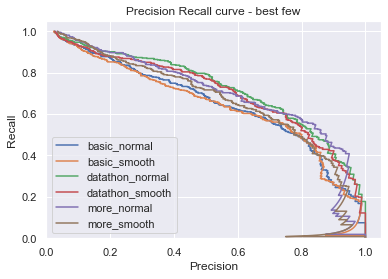

In [84]:
lab = ["basic", "basic_drug", "datathon", "datathon_drug", "more", "more_drug"]
typ = ["normal", "ema", "smooth"]
for i in [0, 2, 6, 8, 12, 14]:
    test_y, pred_y = test[i], pred[i]
    pred_y = pred_y.copy()
    precision, recall, _ = precision_recall_curve(test_y, pred_y[:, 1])
    plt.plot(precision, recall, label=f"{lab[int(i/3)]}_{typ[i%3]}")
plt.title('Precision Recall curve - best few')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.xlim(0,)
plt.ylim(0,)
plt.legend()
plt.savefig("plots/Precision Recall curve - best few.png")
plt.show()

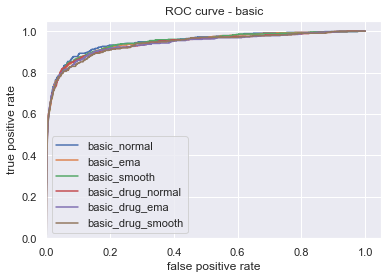

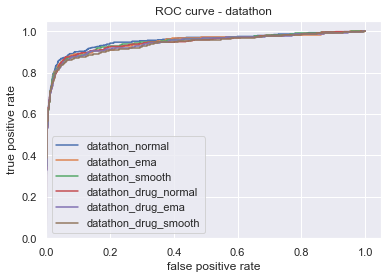

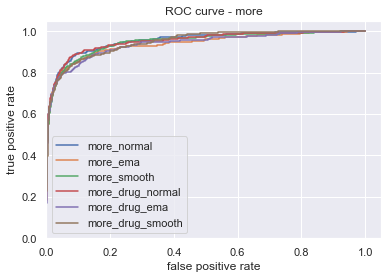

In [86]:
lab = ["basic", "basic_drug", "datathon", "datathon_drug", "more", "more_drug"]
typ = ["normal", "ema", "smooth"]
for i in range(18):
    test_y, pred_y = test[i], pred[i]
    pred_y = pred_y.copy()
    fpr, tpr, _ = roc_curve(test_y, pred_y[:, 1])
    plt.plot(fpr, tpr, label=f"{lab[int(i/3)]}_{typ[i%3]}")
    if i>0 and i%6==5:
        plt.title('ROC curve - ' + lab[int(i/6)*2])
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.xlim(0,)
        plt.ylim(0,)
        plt.legend()
        plt.savefig(f"plots/ROC curve - {lab[int(i/6)*2]}.png")
        plt.show()

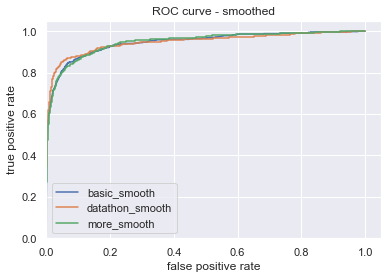

In [85]:
lab = ["basic", "basic_drug", "datathon", "datathon_drug", "more", "more_drug"]
typ = ["normal", "ema", "smooth"]
for i in [2, 8, 14]:
    test_y, pred_y = test[i], pred[i]
    pred_y = pred_y.copy()
    fpr, tpr, _ = roc_curve(test_y, pred_y[:, 1])
    plt.plot(fpr, tpr, label=f"{lab[int(i/3)]}_{typ[i%3]}")
plt.title('ROC curve - smoothed')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.legend()
plt.savefig("plots/ROC curve - smoothed.png")
plt.show()

In [ ]:
lab = ["basic", "basic_drug", "datathon", "datathon_drug", "more", "more_drug"]
typ = ["normal", "ema", "smooth"]

with open("results_report_02.txt", "w") as f:
    for i in range(18):
        test_y, pred_y = test[i], pred[i]
        pred_y = pred_y.copy()
        pred_y[:, 0] -= 0.2
        pred_y[:, 1] += 0.2
        f.write(f"{lab[int(i/3)]}_{typ[i%3]}\n")
        f.write("---------------------------------------------\n")
        f.write(classification_report(test_y, np.argmax(pred_y,axis=1)))
        f.write("\n\n")

In [8]:
from sklearn.metrics import roc_auc_score